<a href="https://colab.research.google.com/github/288756/VisArtificial/blob/master/TrabajoGrafos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Primero, instalamos PyPDF2 para manipular PDFs, Louvain para las comunidades e importamos las librerías necesarias

In [24]:
import networkx as nx
!pip install PyPDF2
!pip install python-louvain
import community.community_louvain as community_louvain
import PyPDF2
import matplotlib.cm as cm
import re
import matplotlib.pyplot as plt

In [10]:
capitulos = []
# Definimos el patrón para buscar el nombre del personaje y la ubicación, que están separados por números romanos. Hacemos que no incluya
# la región dentro del propio patrón, ya que esta información no nos interesa.

pattern = r"([A-Za-z\s]+)\s\b(?:[IVXLCDM]+)\b\s(.*?)(?=(?:North|Riverlands|Crownlands|Vale|Iron Islands|Reach|Stormlands|Dorne|Free Cities|Dothraki Sea|Far East|Slaver's Bay|Rhoyne|Beyond-the-Wall|Open oceans|$))"
# Abre el archivo PDF en modo lectura binaria ('rb')
with open('asoiaf_places.pdf', 'rb') as file:
    # Creamos el objeto PDFReader.
    pdf_reader = PyPDF2.PdfReader(file)
    # Obtenemos el número de páginas del PDF
    num_pages = len(pdf_reader.pages)

    # Iteramos sobre cada página y extraemos su contenido
    for page_num in range(2, 11):  # Las páginas relevantes del PDF están en este rango
        # Obtenemos la página
        page = pdf_reader.pages[page_num]

        # Extraemos el texto de la página
        text = page.extract_text()

        # Buscamos coincidencias con el patrón en el texto de la página
        matches = re.findall(pattern, text)

        # Hacemos una tupla con el nombre del personaje y su ubicación en ese capítulo, posteriormente lo añadimos a una lista
        for match in matches:
            character = match[0].strip()  # Nombre del personaje
            location = match[1].strip()   # Ubicación
            capitulos.append((character, location))

        # Por alguna razón, hay ejemplos en los que el patrón no reconoce la ubicación y devuelve un elemento vacío.
        # Como son pocas veces las que sucede esto, relleno los datos manualmente.
        for i, tupla in enumerate(capitulos):
            if tupla[0] == 'Daenerys' and tupla[1] == '':
              capitulos[i] = (tupla[0], 'Dothraki Sea')
            elif tupla[0] == 'Arya' and tupla[1] == '':
              capitulos[i] = (tupla[0], 'Harrenhal')
            elif tupla[0] == 'Victarion' and tupla[1] == '':
              capitulos[i] = (tupla[0], 'Slaver\'s Bay')
            elif tupla[0] == 'Brienne' and tupla[1] == '':
              capitulos[i] = (tupla[0], 'Red Fork')
            elif tupla[0] == 'Tyrion' and tupla[1] == '':
              capitulos[i] = (tupla[0], 'Rhoyne')

Se imprime por pantalla la lista "capitulos" para comprobar que se ha generado correctamente.

In [3]:
capitulos

[('Bran', 'Near Winterfell'),
 ('Catelyn', 'Winterfell'),
 ('Daenerys', 'Pentos'),
 ('Eddard', 'Winterfell'),
 ('Jon', 'Winterfell'),
 ('Catelyn', 'Winterfell'),
 ('Arya', 'Winterfell'),
 ('Bran', 'Winterfell'),
 ('Tyrion', 'Winterfell'),
 ('Jon', 'Winterfell'),
 ('Daenerys', 'Outside Pentos'),
 ('Eddard', 'Kingsroad / Barrowlands'),
 ('Tyrion', 'Kingsroad (north of Winterfell)'),
 ('Catelyn', 'Winterfell'),
 ('Sansa', 'Crossroads Inn'),
 ('Eddard', 'Darry'),
 ('Bran', 'Winterfell'),
 ('Catelyn', "Blackwater Bay / King's Landing"),
 ('Jon', 'Castle Black'),
 ('Eddard', "King's Landing"),
 ('Tyrion', 'Castle Black'),
 ('Arya', "King's Landing"),
 ('Daenerys', 'Dothraki Sea'),
 ('Bran', 'Winterfell'),
 ('Eddard', "King's Landing"),
 ('Jon', 'Castle Black'),
 ('Eddard', "King's Landing"),
 ('Catelyn', 'Crossroads Inn'),
 ('Sansa', "King's Landing"),
 ('Eddard', "King's Landing"),
 ('Tyrion', 'The High Road'),
 ('Arya', "King's Landing"),
 ('Eddard', "King's Landing"),
 ('Catelyn', 'Bloody

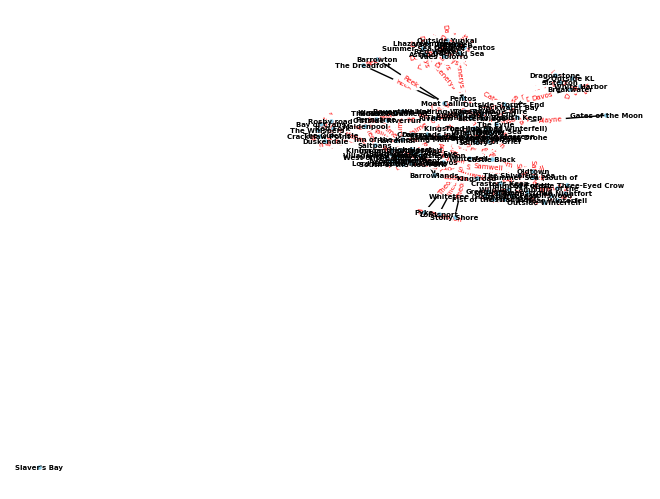

In [11]:
# Creamos el grafo y un diccionario para mapear las ciudades a los personajes que han estado en ellas
G = nx.Graph()
city_characters = {}

# Iteramos sobre cada tupla en la lista original
for personaje, lugar in capitulos:
    if '/' in lugar:
        # Si hay una barra, dividimos el lugar en dos partes. Esto quiere decir que en
        # un capítulo el personaje ha estado en dos zonas distintas. Evitamos duplicados
        # con conjuntos.
        lugares = lugar.split(' / ')
        for l in lugares:
            if l not in city_characters:
                city_characters[l] = set()
            city_characters[l].add(personaje)
    else:
        if lugar not in city_characters:
            city_characters[lugar] = set()
        city_characters[lugar].add(personaje)

# Agregamos nodos al grafo para cada ciudad
for ciudad in city_characters:
    G.add_node(ciudad)

# Agregamos arcos entre ciudades que comparten al menos un personaje
for ciudad1 in city_characters:
    for ciudad2 in city_characters:
        if ciudad1 != ciudad2 and city_characters[ciudad1] & city_characters[ciudad2]:
            G.add_edge(ciudad1, ciudad2, personajes=sorted(city_characters[ciudad1] & city_characters[ciudad2]))

# Obtenemos la posición de los nodos en el grafo
pos = nx.spring_layout(G)

# Dibujamos el grafo con los nodos y arcos
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=5, font_size=5, font_weight='bold')

# Se agregan etiquetas a los arcos con los personajes
edge_labels = {(u, v): ', '.join(data['personajes']) for u, v, data in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red', font_size=5)

# Por último, mostramos el grafo
plt.show()


In [12]:
# Implementamos diferentes medidas de centralidad y obtenemos los 5 nodos con mayor valor en cada medida de centralidad
degree = nx.degree_centrality(G)
closeness = nx.closeness_centrality(G)
betweenness = nx.betweenness_centrality(G)
eigenvector = nx.eigenvector_centrality(G)

top5_degree = sorted(degree.items(), key=lambda x: x[1], reverse=True)[:5]
top5_closeness = sorted(closeness.items(), key=lambda x: x[1], reverse=True)[:5]
top5_betweenness = sorted(betweenness.items(), key=lambda x: x[1], reverse=True)[:5]
top5_eigenvector = sorted(eigenvector.items(), key=lambda x: x[1], reverse=True)[:5]

# Imprimir los resultados
print("Top 5 nodos con mayor valor en Degree Centrality:")
print(top5_degree)
print("\nTop 5 nodos con mayor valor en Closeness Centrality:")
print(top5_closeness)
print("\nTop 5 nodos con mayor valor en Betweenness Centrality:")
print(top5_betweenness)
print("\nTop 5 nodos con mayor valor en Eigenvector Centrality:")
print(top5_eigenvector)

Top 5 nodos con mayor valor en Degree Centrality:
[('Winterfell', 0.6448598130841121), ("King's Landing", 0.5420560747663551), ('Crossroads Inn', 0.5233644859813084), ('Castle Black', 0.308411214953271), ('The Eyrie', 0.2803738317757009)]

Top 5 nodos con mayor valor en Closeness Centrality:
[('Winterfell', 0.7343310894712763), ("King's Landing", 0.6818788687947567), ('Crossroads Inn', 0.6731368320153367), ('The Eyrie', 0.5769744274417172), ('Castle Black', 0.5645663752386695)]

Top 5 nodos con mayor valor en Betweenness Centrality:
[('Winterfell', 0.33330728373489804), ('Pentos', 0.18427085170163993), ('Crossroads Inn', 0.1643908859611558), ("King's Landing", 0.14919568763687968), ('Castle Black', 0.058257512780524656)]

Top 5 nodos con mayor valor en Eigenvector Centrality:
[('Winterfell', 0.28143923131838816), ("King's Landing", 0.2760228776990244), ('Crossroads Inn', 0.2673666823046482), ('Harrenhal', 0.17794142128252072), ('Inn of the Kneeling Man', 0.17794142128252072)]


Estos valores son bastante acertados ya que Winterfell y King's Landing son los dos lugares más emblemáticos de Juego de Tronos, también aparecen zonas recurrentes como Pentos, Castle Black o la posada Crossroads. Ahora, vamos a mostrar el grafo pero por comunidades usando Louvain.

<ipython-input-32-4e2bcdff3c35>:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('viridis', num_communities)


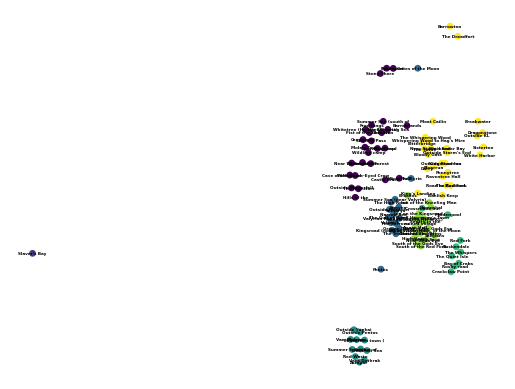

In [32]:
comunidades = community_louvain.best_partition(G)
# Dibujamos el grafo con los nodos coloreados según la comunidad a la que pertenecen
# Posición de los nodos en el grafo
pos = nx.spring_layout(G)

# Se asigna un color diferente a cada comunidad
num_communities = max(comunidades.values()) + 1
colors = cm.get_cmap('viridis', num_communities)
node_colors = [colors(comunidades[node]) for node in G.nodes]

# Dibujar el grafo con los nodos coloreados según la comunidad a la que pertenecen
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=15)
nx.draw_networkx_labels(G, pos, font_size=3, font_weight='bold')

# Mostrar el grafo
plt.axis("off")
plt.show()